In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd

import requests
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import scipy.stats as ss

sys.path.append('../../src/')
import toolbox
from copulae1 import *
import KDEs as K


In [87]:
# stats.uniform
C = Gumbel({'theta':4}, stats.uniform, stats.uniform)

In [88]:
uv = C.sample(1000)

../../src/copulae1.py:682: RuntimeWarning: invalid value encountered in power
  G_hat = lambda t: np.exp(-t ** (1 / self.theta))


In [90]:
scipy.stats.kendalltau(uv[:,0], uv[:,1])

KendalltauResult(correlation=0.7465025025025025, pvalue=1.0815886517483835e-273)

In [92]:
scipy.stats.kendalltau(1-uv[:,0], 1-uv[:,1])

KendalltauResult(correlation=0.7465025025025025, pvalue=1.0815886517483835e-273)

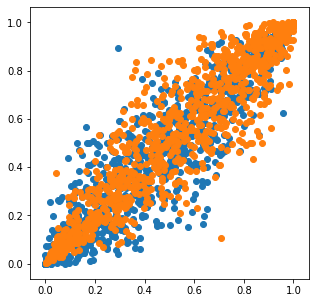

In [45]:
plt.figure(figsize=(5,5))
plt.scatter(uv[:,0], uv[:,1])
plt.scatter(1-uv[:,0], 1-uv[:,1])

In [50]:
df

,Unnamed: 0,Date,PX_LAST,contract_name,xrp Price,log return future,log return xrp
0,115,2020-12-11 21:00:00+00:00,18165.0,BTCF1 Curncy,0.571409,-0.023127,-0.009157
1,116,2020-12-10 21:00:00+00:00,18590.0,BTCF1 Curncy,0.576666,-0.000538,0.002375
2,117,2020-12-09 21:00:00+00:00,18600.0,BTCF1 Curncy,0.575298,-0.019697,0.012047
3,118,2020-12-08 21:00:00+00:00,18970.0,BTCF1 Curncy,0.568409,-0.018023,-0.058638
4,119,2020-12-07 21:00:00+00:00,19315.0,BTCF1 Curncy,0.602736,0.003631,0.058527
...,...,...,...,...,...,...,...
295,410,2019-10-11 20:00:00+00:00,8415.0,BTCX19 Curncy,0.270009,-0.027543,-0.009166
296,411,2019-10-10 20:00:00+00:00,8650.0,BTCX19 Curncy,0.272496,-0.004038,-0.032480
297,412,2019-10-09 20:00:00+00:00,8685.0,BTCX19 Curncy,0.281492,0.054419,0.024151
298,413,2019-10-08 20:00:00+00:00,8225.0,BTCX19 Curncy,0.274775,-0.007872,-0.003402


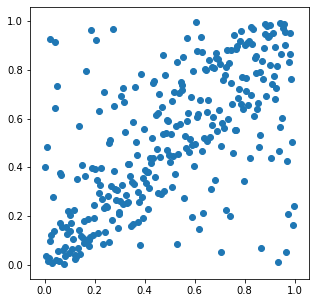

In [114]:
df = pd.read_csv('../../processed_data/BBT_future_Tiingo_xrp/train/0.csv')
rs = df.loc[:,'log return xrp']
rf = df.loc[:,'log return future']

kde_rs = K.KDE(rs, 'Gaussian')
kde_rf = K.KDE(rf, 'Gaussian')

u = kde_rs.cdf(rs)
v = kde_rf.cdf(rf)
plt.figure(figsize=(5,5))
plt.scatter(u, v)

# plt.figure(figsize=(5,5))
# plt.scatter(rs, rf)
# df.Date.iloc[0]

In [63]:
C.canonical_calibrate(u,v)

Optimization terminated successfully.
         Current function value: -61.008197
         Iterations: 34
         Function evaluations: 73


1.6932546890060696

In [64]:
C.canonical_calibrate(1-u,1-v)

Optimization terminated successfully.
         Current function value: -76.536503
         Iterations: 32
         Function evaluations: 68


1.8019391293179203

In [65]:
C.mm_calibrate(u, v, [0.05,0.1,0.9, 0.95])

Optimization terminated successfully.
         Current function value: 0.141111
         Iterations: 36
         Function evaluations: 78


array([1.48359683])

In [66]:
C.mm_calibrate(1-u, 1-v, [0.05,0.1,0.9, 0.95])

Optimization terminated successfully.
         Current function value: 0.037878
         Iterations: 33
         Function evaluations: 72


array([1.54062207])

In [68]:
uv = C.sample(1000)

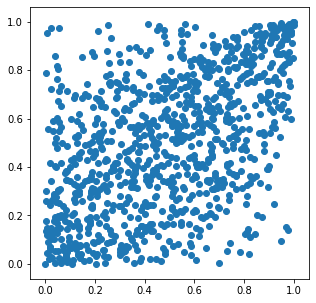

In [70]:
plt.figure(figsize=(5,5))
plt.scatter(uv[:,0], uv[:,1])

In [256]:
class rot180Gumbel(Gumbel):
    def C(self, u, v):
        u = 1-u
        v = 1-v
        return self.phi_inverse(self.phi(u) + self.phi(v))
    
    def c(self, u, v):  
        u = 1-u
        v = 1-v
        
        u_t = -np.log(u)
        v_t = -np.log(v)
        part1 = self.C(1-u, 1-v) / (u * v)
        part2 = (u_t * v_t) ** (self.theta - 1) / (u_t ** self.theta + v_t ** self.theta) ** (2 - 1 / self.theta)
        part3 = (u_t ** self.theta + v_t ** self.theta) ** (1 / self.theta) + self.theta - 1
        return part1 * part2 * part3

    def Gumbel_copula(self, u, v, theta):  # Copula function for calibration
        u = 1-u
        v = 1-v

        t1 = (-np.log(u)) ** theta
        t2 = (-np.log(v)) ** theta
        part1 = t1 + t2
        part2 = part1 ** (1 / theta)
        return np.exp(-part2)
    
    def l_fn(self, theta, u, v, verbose=False):
        u = 1-u # the rotation is in effect in this function, no rotation is needed 
        v = 1-v
        
        if theta < 1:
            print("theta is smaller then 1; consider changing x0 of fmin by initiating the class with different theta")
            return -5000
        try:  # turn u==1 to a slightly smaller number to avoid inf
            u[u == 1] = max(u[u != 1]) + 0.9 / len(u)
            v[v == 1] = max(v[v != 1]) + 0.9 / len(v)
        except:
            pass
        t1 = -np.log(u)
        t2 = -np.log(v)
        part1 = 1 / (u * v)
        part2 = self.Gumbel_copula(1-u, 1-v, theta)
        part3 = t1 ** (-1 + theta)
        part4 = t2 ** (-1 + theta)
        part5 = -1 + theta + (t1 ** theta + t2 ** theta) ** (1 / theta)
        part6 = (t1 ** theta + t2 ** theta) ** (-2 + (1 / theta))
        if np.sum(np.isfinite(part6)) > 0:
            part6[~np.isfinite(part6)] = np.max(part6[np.isfinite(part6)]) * 10
        else:
            part6[~np.isfinite(part6)] = 100
        if verbose:
            print(part1, part2, part3, part4, part5, part6)
        return np.sum(np.log(part1 * part2 * part3 * part4 * part5 * part6))

    def sample(self, size):
        samples = np.zeros((size, 2))
        gamma = np.cos(np.pi / (2 * self.theta)) ** self.theta
        V = stable(1 / self.theta, 1, 0, gamma).rvs(size)
        G_hat = lambda t: np.exp(-t ** (1 / self.theta))

        X1 = stats.uniform.rvs(size=size)
        X2 = stats.uniform.rvs(size=size)

        U1 = G_hat(-np.log(X1) / V)
        U2 = G_hat(-np.log(X2) / V)

        # samples of stable contain NaNs; Draw more samples and discard NaNs until len(V) = size
        nan_id = np.isnan(U1)
        while np.sum(nan_id) != 0:
            size1 = np.sum(nan_id)
            V = stable(1 / self.theta, 1, 0, gamma).rvs(size1)
            X1 = stats.uniform.rvs(size=size1)
            X2 = stats.uniform.rvs(size=size1)

            U1[nan_id] = G_hat(-np.log(X1) / V)
            U2[nan_id] = G_hat(-np.log(X2) / V)
            nan_id = np.isnan(U1)

        samples[:, 0] = self.Law_RS.ppf(1-U1)
        samples[:, 1] = self.Law_RF.ppf(1-U2)
        return samples
    
    def _lambda(self, q):
        q = 1-q
        if q <= 0.5:
            return self.C(1-q, 1-q) / q
        else:
            return (1 - (2 * q) + self.C(1-q, 1-q)) / (1 - q)

In [257]:
C.theta

3

In [258]:
rotC.theta

3

In [259]:
C = Gumbel({'theta':3}, stats.uniform, stats.uniform)


rotC = rot180Gumbel({'theta':3}, stats.uniform, stats.uniform)
# print(C.Gumbel_copula(0.1,0.1, 1.2), 
#         rotC.Gumbel_copula(0.9,0.9, 1.2))

# print(C.l_fn(1.2, np.array([0.1]),np.array([0.1])))
# print(rotC.l_fn(1.2, np.array([1-0.1]),np.array([1-0.1])))


print(C._lambda(0.1))
print(rotC._lambda(1-0.1))


0.5496407836087126
0.5496407836087123


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in double_scalars


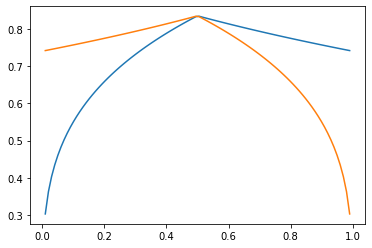

In [260]:
q_arr = np.linspace(0,1,100)

plt.plot(q_arr, [C._lambda(q) for q in q_arr])
plt.plot(q_arr, [rotC._lambda(q) for q in q_arr])

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in power
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in double_scalars


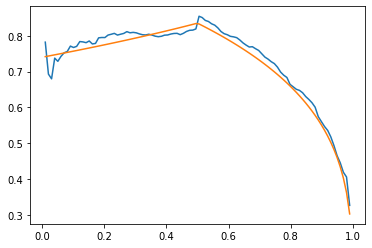

In [263]:
uv = rotC.sample(10000)

plt.plot(q_arr, [empirical_lambda(uv[:,0], uv[:,1], q) for q in q_arr])
plt.plot(q_arr, [rotC._lambda(q) for q in q_arr])

In [214]:
rotC.C(1-0.1,1-0.1)/.1

0.16527324863004178

In [171]:
rotC.c(0.1,0.1)

1.4709160305546698

In [282]:
C = Gumbel({'theta':3}, stats.uniform, stats.uniform)
uv = C.sample(1000)
# C.canonical_calibrate(uv[:,0],uv[:,1])
C.mm_calibrate(uv[:,0], uv[:,1], [0.05, 0.1,0.9, 0.95])
print(C.theta)
rotC = rot180Gumbel({'theta':3}, stats.uniform, stats.uniform)
# rotuv = rotC.sample(1000)
# rotC.canonical_calibrate(1-uv[:,0], 1-uv[:,1])
# rotC.canonical_calibrate(1-u,1-v)
rotC.mm_calibrate(1-uv[:,0], 1-uv[:,1], [0.05, 0.1,0.9, 0.95])
print(rotC.theta)

Optimization terminated successfully.
         Current function value: 0.010477
         Iterations: 35
         Function evaluations: 74
2.762937319278716
Optimization terminated successfully.
         Current function value: 0.010477
         Iterations: 35
         Function evaluations: 76
2.762937319278716


In [283]:
scipy.stats.kendalltau(uv[:,0], uv[:,1])[0] - scipy.stats.kendalltau(1-uv[:,0], 1-uv[:,1])[0]

0.0

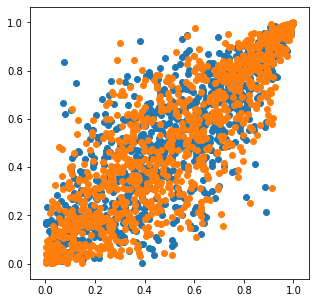

In [285]:
rotuv = rotC.sample(1000)

plt.figure(figsize=(5,5))
plt.scatter(uv[:,0], uv[:,1])
plt.scatter(1-rotuv[:,0], 1-rotuv[:,1])

In [2]:
C = Gumbel({'theta':3}, stats.uniform, stats.uniform)
rotC = rot180Gumbel({'theta':3}, stats.uniform, stats.uniform)

In [8]:
print(rotC.C(1-0.1,1-0.1) - C.C(0.1,0.1), 
      rotC.c(1-0.1,1-0.1) - C.c(0.1,0.1))

-4.85722573273506e-17 8.881784197001252e-16


In [13]:
df = pd.read_csv('../../processed_data/BBT_future_Tiingo_xrp/train/0.csv')
rs = df.loc[:,'log return xrp']
rf = df.loc[:,'log return future']

kde_rs = K.KDE(rs, 'Gaussian')
kde_rf = K.KDE(rf, 'Gaussian')

u = kde_rs.cdf(rs)
v = kde_rf.cdf(rf)

C.canonical_calibrate(1-u,1-v)
rotC.canonical_calibrate(u, v)
print(C.theta, rotC.theta)

C.mm_calibrate(1-u,1-v, [0.05, 0.1, 0.9, 0.95])
rotC.mm_calibrate(u, v, [0.05, 0.1, 0.9, 0.95])
print(C.theta, rotC.theta)

Optimization terminated successfully.
         Current function value: -76.536503
         Iterations: 31
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: -76.536503
         Iterations: 31
         Function evaluations: 67
1.8019391451071711 1.8019391393578406
Optimization terminated successfully.
         Current function value: 0.037878
         Iterations: 33
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 0.037878
         Iterations: 33
         Function evaluations: 72
1.5406220875574699 1.5406220826419064
